In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

EPOCH_KEY = 'epoch'
G_MODEL_STATE_KEY = 'g_model_state'
D_MODEL_STATE_KEY = 'd_model_state'
G_OPTIMIZER_STATE_KEY = 'g_optimizer_state'
D_OPTIMIZER_STATE_KEY = 'd_optimizer_state'

def save_checkpoint(path, epoch, g_model, g_optimizer, d_model, d_optimizer):
    checkpoint_data = {
        EPOCH_KEY: epoch,
        G_MODEL_STATE_KEY: g_model.state_dict(),
        G_OPTIMIZER_STATE_KEY: g_optimizer.state_dict(),
        D_MODEL_STATE_KEY: d_model.state_dict(),
        D_OPTIMIZER_STATE_KEY: d_optimizer.state_dict(),
    }

    torch.save(checkpoint_data, path)

class CheckpointLoader:
    def __init__(self, path):
        self.checkpoint = torch.load(path, weights_only=True)

    def load_models(self, g_model, d_model):
        g_model.load_state_dict(self.checkpoint[G_MODEL_STATE_KEY])
        d_model.load_state_dict(self.checkpoint[D_MODEL_STATE_KEY])

    def load_optimizers(self, g_optimizer, d_optimizer):
        g_optimizer.load_state_dict(self.checkpoint[G_OPTIMIZER_STATE_KEY])
        d_optimizer.load_state_dict(self.checkpoint[D_OPTIMIZER_STATE_KEY])

    def load_epoch(self):
        return self.checkpoint[EPOCH_KEY]

In [ ]:
import argparse
import os
import random

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torchvision import datasets

import torch.nn as nn
import torch

from pathlib import Path

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

save_path = Path('/content/drive/MyDrive/DataScience/HW4_ver3')
checkpoints_path = save_path / "checkpoints"
images_path = save_path / "images"

checkpoints_path.mkdir(parents=True, exist_ok=True)
images_path.mkdir(parents=True, exist_ok=True)

checkpoint_loader: CheckpointLoader = None#CheckpointLoader(checkpoints_path / "checkpoint_10.tar")

cli = False

if cli:
    parser = argparse.ArgumentParser()
    parser.add_argument("--n_epochs", type=int, default=250, help="number of epochs of training")
    parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
    parser.add_argument("--lr", type=float, default=0.0005, help="adam: learning rate")
    parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
    parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
    parser.add_argument("--noise_channels", type=int, default=256, help="dimensionality of the latent space")
    parser.add_argument("--g_features", type=int, default=64, help="generator features")
    parser.add_argument("--d_features", type=int, default=64, help="discriminator features")
    parser.add_argument("--img_size", type=int, default=64, help="size of each image dimension")
    parser.add_argument("--channels", type=int, default=1, help="number of image channels")
    parser.add_argument("--sample_interval", type=int, default=50, help="interval between image sampling")
    parser.add_argument("--checkpoint_interval", type=int, default=10, help="interval between checkpoint saving")
    opt = parser.parse_args()
    print(opt)
else:
    opt = argparse.Namespace()
    opt.n_epochs = 1000
    opt.batch_size = 64
    opt.lr = 0.0002
    opt.b1 = 0.5
    opt.b2 = 0.999
    opt.noise_channels = 100
    opt.g_features = 64
    opt.d_features = 64
    opt.img_size = 28
    opt.channels = 1
    opt.sample_interval = 50
    opt.checkpoint_interval = 5
    print(opt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(opt.noise_channels, opt.g_features * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(opt.g_features * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(opt.g_features * 8, opt.g_features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(opt.g_features * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(opt.g_features * 4, opt.g_features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(opt.g_features * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(opt.g_features * 2, opt.g_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(opt.g_features),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(opt.g_features, opt.channels, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(opt.channels, opt.d_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.d_features, opt.d_features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(opt.d_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.d_features * 2, opt.d_features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(opt.d_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.d_features * 4, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

if checkpoint_loader:
    checkpoint_loader.load_models(generator, discriminator)

generator = generator.to(device)
discriminator = discriminator.to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

#if checkpoint_loader:
#    checkpoint_loader.load_optimizers(optimizer_G, optimizer_D)

# Configure data loader
os.makedirs("./data", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

fixed_noise = torch.randn(64, opt.noise_channels, 1, 1, device=device)
real_label = 1.
fake_label = 0.

start_epoch = 0

if checkpoint_loader:
    start_epoch = checkpoint_loader.load_epoch()

# ----------
#  Training
# ----------

for epoch in range(start_epoch, opt.n_epochs, 1):
    generator.train()
    discriminator.train()

    for i, (imgs, _) in enumerate(dataloader):
        discriminator.zero_grad()
        real_cpu = imgs.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = discriminator(real_cpu).view(-1)
        real_d_loss = adversarial_loss(output, label)
        real_d_loss.backward()

        noise = torch.randn(batch_size, opt.noise_channels, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        fake_d_loss = adversarial_loss(output, label)
        fake_d_loss.backward()
        d_loss = real_d_loss + fake_d_loss
        optimizer_D.step()

        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        g_loss = adversarial_loss(output, label)
        g_loss.backward()
        optimizer_G.step()

        batches_done = epoch * len(dataloader) + i
        if i % opt.sample_interval == 0:
            with torch.no_grad():
                generator.eval()
                fake_images = generator(fixed_noise).detach().cpu()
                save_image(fake_images[:25], images_path / f"{epoch}_{batches_done}.png", nrow=5, normalize=True)

    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch + 1, opt.n_epochs, d_loss.item(), g_loss.item())
    )

    if epoch % opt.checkpoint_interval == 0:
        save_checkpoint(checkpoints_path / f"checkpoint_{epoch}.tar", epoch, generator, optimizer_G, discriminator, optimizer_D)

drive.flush_and_unmount()

Namespace(n_epochs=1000, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, noise_channels=100, g_features=64, d_features=64, img_size=28, channels=1, sample_interval=50, checkpoint_interval=5)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.93MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.36MB/s]


[Epoch 1/1000] [D loss: 0.172439] [G loss: 4.031553]
[Epoch 2/1000] [D loss: 0.377920] [G loss: 2.042230]
[Epoch 3/1000] [D loss: 0.919204] [G loss: 1.074423]
[Epoch 4/1000] [D loss: 0.497953] [G loss: 2.614270]
[Epoch 5/1000] [D loss: 0.901567] [G loss: 1.659905]
[Epoch 6/1000] [D loss: 0.627712] [G loss: 2.322920]
[Epoch 7/1000] [D loss: 0.741850] [G loss: 1.737872]
[Epoch 8/1000] [D loss: 0.476786] [G loss: 2.731650]
[Epoch 9/1000] [D loss: 1.089446] [G loss: 0.813297]
[Epoch 10/1000] [D loss: 1.073123] [G loss: 1.031737]
[Epoch 11/1000] [D loss: 0.598148] [G loss: 1.944441]
[Epoch 12/1000] [D loss: 0.771790] [G loss: 2.676198]
[Epoch 13/1000] [D loss: 0.757562] [G loss: 1.791139]
[Epoch 14/1000] [D loss: 0.808565] [G loss: 1.698751]
[Epoch 15/1000] [D loss: 0.791098] [G loss: 2.936763]
[Epoch 16/1000] [D loss: 1.158855] [G loss: 2.699581]
[Epoch 17/1000] [D loss: 0.749482] [G loss: 1.769295]
[Epoch 18/1000] [D loss: 0.836532] [G loss: 3.013003]
[Epoch 19/1000] [D loss: 0.623503] [G

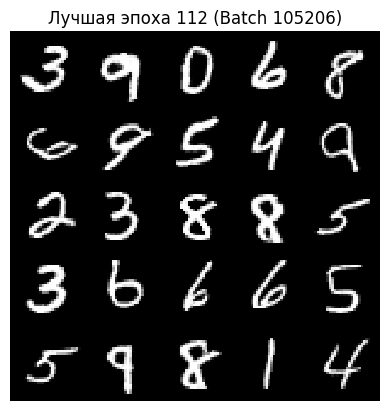

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_name = '112_105206.png'
img = mpimg.imread(f'./images/{image_name}')

plt.imshow(img, interpolation='nearest')
plt.title("Лучшая эпоха 112 (Batch 105206)")
plt.axis('off')
plt.show()